# Plotting Key Global Timeseries in ACCESS-CM3

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [53]:
#parameters

### USER EDIT start
esm_file='/g/data/zv30/non-cmip/ACCESS-CM3/cm3-run-11-08-2025-25km-beta-om3-new-um-params/cm3-demo-datastore/cm3-demo-datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/zv30/non-cmip/ACCESS-CM3/cm3-run-11-08-2025-25km-beta-om3-new-um-params/cm3-demo-datastore/cm3-demo-datastore.json
Plot folder path:  /g/data/tm70/ek4684/access-om3-paper-figs/


In [54]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime
import xarray as xr
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default
import warnings
warnings.filterwarnings('ignore')

In [55]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

/proxy/41901/status


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41901/status,
Dashboard: /proxy/41901/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34341,Workers: 0
Dashboard: /proxy/41901/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43949,Total threads: 1
Dashboard: /proxy/40841/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:39551,


## Load ACCESS-CM3 data from ESM datastore

In [56]:
datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [57]:
soga = datastore.search(variable="soga", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True,
    use_cftime=True))['soga'].sel(time=slice(cftime.datetime(1981, 1, 16,calendar='proleptic_gregorian'), cftime.datetime(2017, 12, 16,calendar='proleptic_gregorian'))).resample(time = '1YE').mean('time').load()

In [58]:
thetaoga = datastore.search(variable="thetaoga", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True,
    use_cftime=True))['thetaoga'].sel(time=slice(cftime.datetime(1981, 1, 16,calendar='proleptic_gregorian'), cftime.datetime(2017, 12, 16,calendar='proleptic_gregorian'))).resample(time = '1YE').mean('time').load()

## Load ACCESS-CM2 data from ACCESS-NRI Catalog

In [59]:
catalog = intake.cat.access_nri

In [60]:
var = catalog.search(variable='temp_global_ave',frequency="1mon")

In [61]:
salt_global_ave = []
temp_global_ave = []
for year in range(1, 51):
    for month in [1, 7]:
        
        fn = f'ocean-scalar-1-daily-ym_{str(year).zfill(4)}_0{month}.nc'
        temp_global_ave.append(xr.open_dataset(f'/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/{fn}').temp_global_ave)
        salt_global_ave.append(xr.open_dataset(f'/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/{fn}').salt_global_ave)

temp_global_ave = xr.concat(temp_global_ave, dim='time')
salt_global_ave = xr.concat(salt_global_ave, dim='time')

## Plot Timeseries

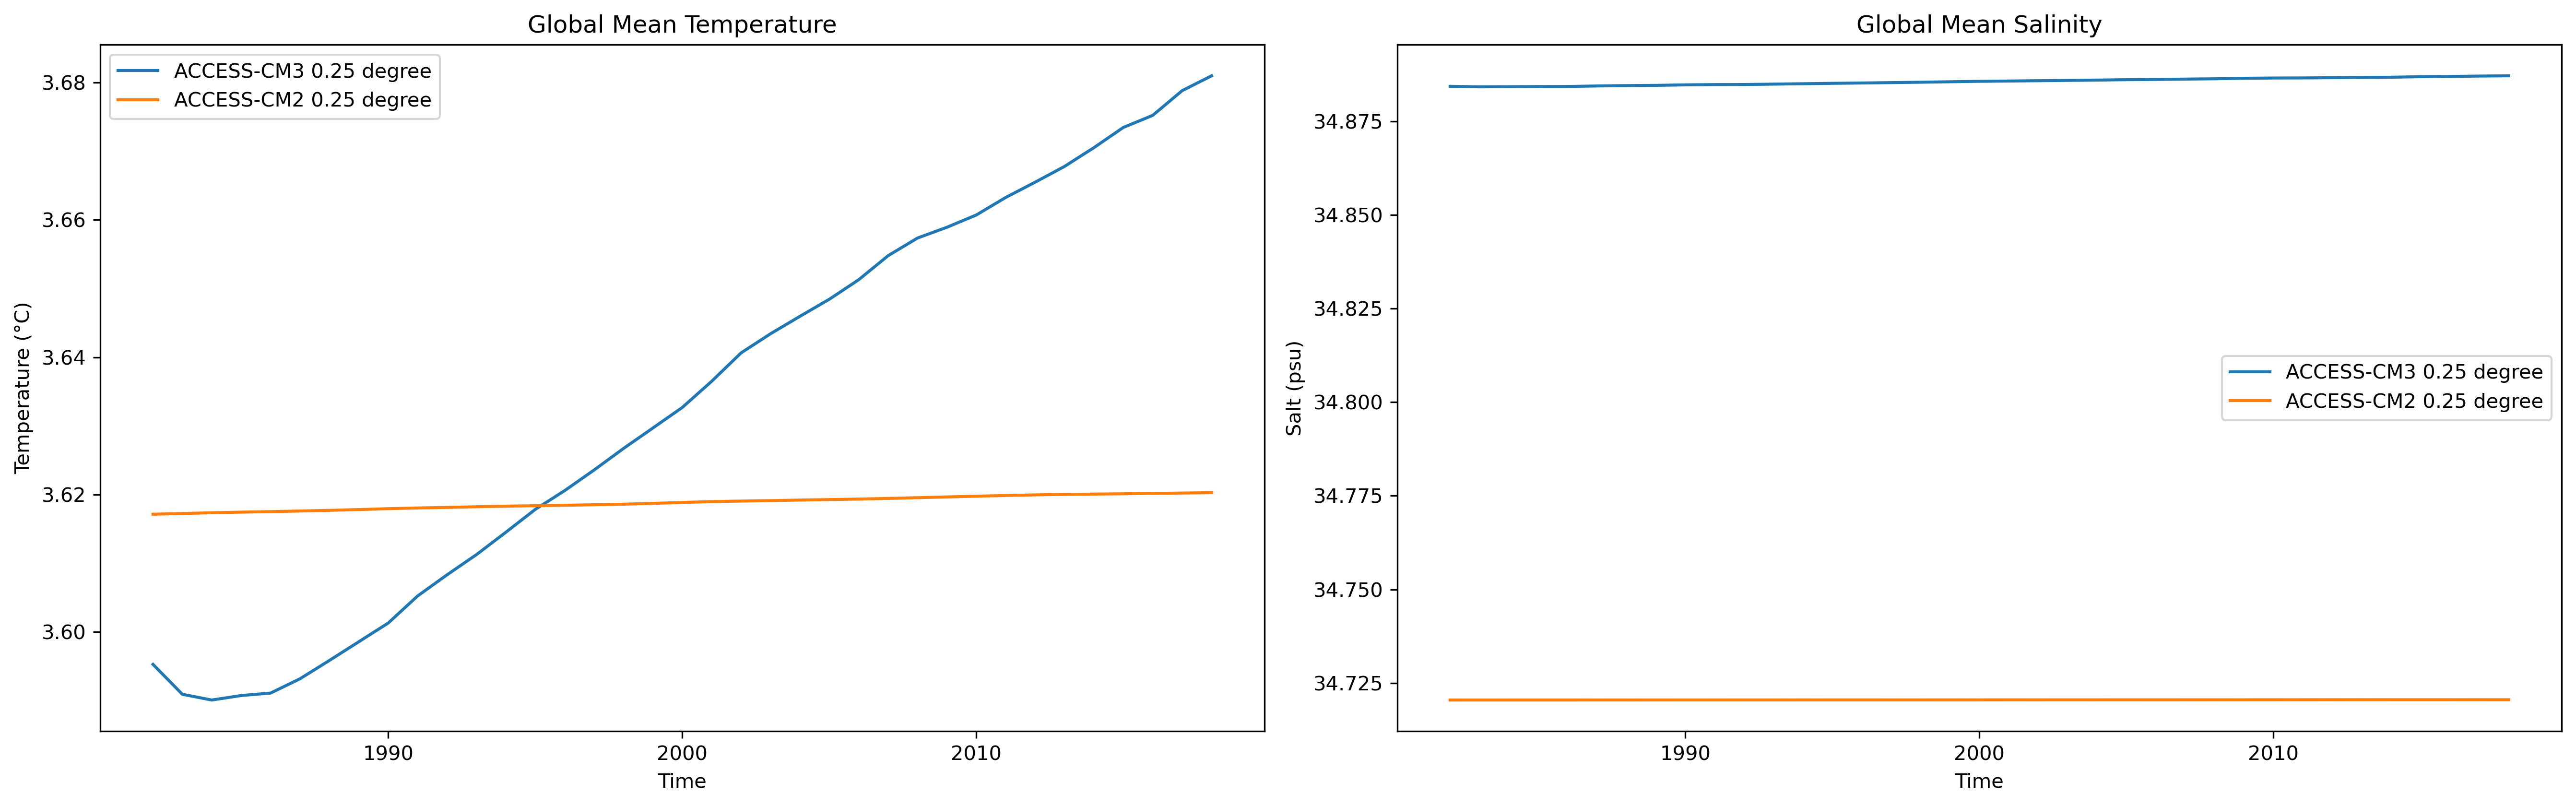

In [64]:
def plot_with_cm3_time(ax, cm3_da, cm2_da, title, ylabel,
                       label_cm3="ACCESS-CM3", label_cm2="ACCESS-CM2"):
    """Plot CM3 directly (its own time), and CM2 against CM3's time (truncated)."""
    # CM3 time is the master x-axis
    cm3_time = cm3_da["time"].values

    # Plot CM3 as-is (keeps its native time coords)
    cm3_da.plot(ax=ax, label=label_cm3)

    # Truncate CM2 to the available CM3 time length (no interpolation)
    n2 = min(len(cm3_time), int(cm2_da.sizes.get("time", cm2_da.shape[0])))
    ax.plot(cm3_time[:n2], cm2_da.isel(time=slice(0, n2)).values, label=label_cm2)

    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel(ylabel)
    ax.legend(loc="best")
    
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1) Global mean temperature: CM3=thetaoga, CM2=temp_global_ave
plot_with_cm3_time(
    axes[0],
    thetaoga,             # CM3
    temp_global_ave,      # CM2
    title="Global Mean Temperature",
    ylabel="Temperature (°C)",
    label_cm3="ACCESS-CM3 0.25 degree",
    label_cm2="ACCESS-CM2 0.25 degree",
)

# 2) Global surface salinity: CM3=sosga, CM2=salt_global_ave
plot_with_cm3_time(
    axes[1],
    soga,                # CM3
    salt_global_ave,     # CM2
    title="Global Mean Salinity",
    ylabel="Salt (psu)",
    label_cm3="ACCESS-CM3 0.25 degree",
    label_cm2="ACCESS-CM2 0.25 degree",
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [63]:
client.close()